In [1]:
import numpy as np
import wave

import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
import random

import struct

from keras.models import *
from keras.layers import *
from keras.callbacks import *

DATA_DIR = './speech_commands_v0.01'

RUN = 1

Using TensorFlow backend.


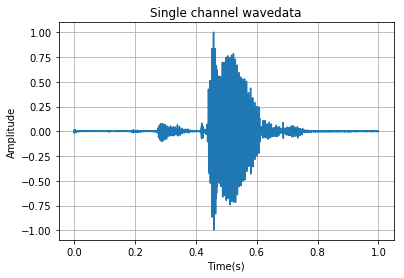

In [26]:
test_file = "{}/bed/0a7c2a8d_nohash_0.wav".format(DATA_DIR)

with wave.open(test_file, 'rb') as f:
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
#     print(nchannels, sampwidth, framerate, nframes) # 1 2 16000 16000
    strData = f.readframes(nframes)#读取音频，字符串格式
#     print(type(strData)) # <class 'bytes'>
#     print(strData[:20]) # b'\xff\xff\xea\xff\xe3\xff\xef\xff\xf6

waveData = np.fromstring(strData, dtype=np.int16)#将字符串转化为int
# print(type(waveData)) # <class 'numpy.ndarray'>
# print(waveData[:20]) # [ -1 -22 -29 -17 -10 -14 -19 -18 -18 -21 -11 8]

waveData_norm = waveData * 1.0 / (max(abs(waveData)))#wave幅值归一化
#     print(type(waveData_norm)) #<class 'numpy.ndarray'>
#     print(waveData_norm[:20]) #[-0.00010379 -0.00228334 -0.00300986 -0.0017644]
# print(waveData_norm.shape) # (16000,)

time = np.arange(0, nframes)*(1.0 / framerate)
plt.plot(time, waveData_norm)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Single channel wavedata")
plt.grid('on')
plt.show()

In [2]:
def get_wave_norm(file):
    with wave.open(file, 'rb') as f:
        params = f.getparams()
        nchannels, sampwidth, framerate, nframes = params[:4]
        data = f.readframes(nframes)
    data = np.fromstring(data, dtype=np.int16)
    data = data * 1.0 / max(abs(data))
    return data

def save_wave(data, file='./save.wav'):
    with wave.open(file, 'wb') as outwave:
        nchannels = 1
        sampwidth = 2
        framerate = 16000
        nframes = data.shape[0]
        comptype = "NONE"
        compname = "not compressed"
        outwave.setparams((nchannels, sampwidth, framerate, nframes, comptype, compname))

        for v in data:
            outwave.writeframes(struct.pack('h', int(v * 64000 / 2)))#outData:16位，-32767~32767，注意不要溢出

In [3]:
MAX_FRAME = 16000
LABELS = ['five', 'happy', 'one', 'house', 'tree', 'bed', 'marvin', 'dog', 'left', 'stop', 'sheila', 
          'four', 'zero', 'cat', 'three', 'two', 'bird', 'yes', 'wow', 'seven', 'on', 'down', 'nine', 
          'right', 'up', 'no', 'eight', 'six', 'off', 'go']
N_CLASS = len(LABELS)

file_glob, noise_glob = [], []
for f in glob('{}/*/*.wav'.format(DATA_DIR)):
    # bug, this wav has no sound
    if f.find('bird/3e7124ba_nohash_0.wav') != -1:
        continue
    
    if f.find('/_background_noise_/') == -1:
        file_glob.append(f)
    else:
        noise_glob.append(f)

noize_data = [get_wave_norm(f) for f in noise_glob]
noize_data = np.concatenate(noize_data, axis=0)

In [4]:
def add_noise(w):
    idx = random.randint(0, noize_data.shape[0] - w.shape[0])
    w = w + noize_data[idx:idx+w.shape[0]] / 5.0
    w = w * 1.0 / (max(abs(w)))
    return w

def get_wave(file):
    data = get_wave_norm(file)
    
#     if random.random() >= 0.5:
#         data = add_noise(data)

    wave_data = np.zeros((MAX_FRAME, ))
    wave_len = min(MAX_FRAME, data.shape[0])
    wave_data[:wave_len] = data[:wave_len]
    
    return np.expand_dims(wave_data, axis=1)

# test
# x = get_wave('{}/bed/0a7c2a8d_nohash_0.wav'.format(DATA_DIR))
# save_wave(x[:,0], 'mix.wav')

def gen(batch_size=32, verbose=False):
    while True:
        X = np.zeros((batch_size, MAX_FRAME, 1), dtype=np.float32)
        y = np.zeros((batch_size, N_CLASS), dtype=np.uint8)
        
        files = np.random.choice(file_glob, batch_size)
        if verbose:
            print(files)
            
        for i in range(batch_size):
            f = files[i]
            X[i] = get_wave(f)
            
            label = f[len(DATA_DIR) + 1:]
            label = label[:label.index('/')]
            label_idx = LABELS.index(label)
            y[i, label_idx] = 1
            
        yield X, y

In [5]:
# class AudioEvaluator(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         print('*******')
#         X_test, y_test = next(gen(1, verbose=True)) # (1, 128, 128, 1)
#         y_pred = self.model.predict(X_test) # (1, 128, 128, AB_PAIRS)
#         print("predict:{}\n*******".format(LABELS[np.argmax(y_pred[0])]))

# evaluator = AudioEvaluator()

def do_train(m):
    global RUN
    RUN += 1
    print("RUN {}".format(RUN))

    LOG_DIR = '/output/training_logs/run-{}'.format(RUN)
    LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

    # tensorboard = TensorBoard(log_dir=LOG_DIR, histogram_freq=1, write_grads=False, write_graph=False)
    tensorboard = TensorBoard(log_dir=LOG_DIR, write_graph=False)
    checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

    history = m.fit_generator(generator=gen(32), steps_per_epoch=256,
                                  validation_data=gen(32), validation_steps=16,
                                  epochs=10000, verbose=1, callbacks=[tensorboard, checkpoint, early_stopping])

# CNN

In [18]:
def get_conv_model():
    m = Sequential()
    m.add(Conv1D(filters=64, kernel_size=2, strides=2, padding='valid', activation='relu', input_shape=(MAX_FRAME,1)))
    m.add(BatchNormalization())
    m.add(Conv1D(filters=64, kernel_size=2, strides=2, padding='valid', activation='relu'))
    m.add(BatchNormalization())
#     m.add(Conv1D(filters=64, kernel_size=2, strides=2, padding='valid', activation='relu'))
#     m.add(BatchNormalization())
    m.add(Flatten())
#     m.add(GlobalAveragePooling1D())
    m.add(Dropout(0.3))
    m.add(Dense(N_CLASS, activation='softmax'))
    m.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return m

In [36]:
m = get_conv_model()
m.summary()
do_train(m)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 8000, 64)          192       
_________________________________________________________________
batch_normalization_21 (Batc (None, 8000, 64)          256       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 4000, 64)          8256      
_________________________________________________________________
batch_normalization_22 (Batc (None, 4000, 64)          256       
_________________________________________________________________
flatten_4 (Flatten)          (None, 256000)            0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256000)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 30)                7680030   
Total para

KeyboardInterrupt: 

# CNN & RNN

In [9]:
def get_cnn_rnn_model():
    ipt = Input(shape=(MAX_FRAME, 1))
    x = ipt
    x = Conv1D(filters=64, kernel_size=50, strides=50, padding='valid', activation='relu')(x)
    x = Conv1D(filters=64, kernel_size=50, strides=50, padding='valid', activation='relu')(x)
    x = BatchNormalization()(x)
    
    # LSTM
    x = LSTM(32)(x)
    
    # double
#     x = LSTM(32, return_sequences=True)(x)
#     x = LSTM(32, return_sequences=False)(x)
    
    # 正反
#     r   = LSTM(32, return_sequences=True, go_backwards=False)(x)
#     r_b = LSTM(32, return_sequences=True, go_backwards=True)(x)
#     x = concatenate([r, r_b])
#     x = Flatten()(x)

    x = Dropout(0.3)(x)
    x = Dense(N_CLASS, activation='softmax')(x)
    
    m = Model(inputs=[ipt], outputs=[x])
    m.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    return m

# get_cnn_rnn_model().summary()

In [14]:
# LSTM with heavy data augumentation(0.8 prob, / 3.0)
m = get_cnn_rnn_model()
m.summary()
do_train(m)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 64)           3264      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 64)             204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 64)             256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                990       
Total para

In [24]:
# LSTM with tiny data augumentation(0.5 prob, / 5.0)
m = get_cnn_rnn_model()
m.summary()
do_train(m)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 320, 64)           3264      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 6, 64)             204864    
_________________________________________________________________
batch_normalization_5 (Batch (None, 6, 64)             256       
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 30)                990       
Total para

In [16]:
# LSTM without data augumentation[Best Model]
m = get_cnn_rnn_model()
m.summary()
do_train(m)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 320, 64)           3264      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 6, 64)             204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 64)             256       
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                990       
Total para

In [ ]:
# LSTM with dropout
m = get_cnn_rnn_model()
m.summary()
do_train(m)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 320, 64)           3264      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 6, 64)             204864    
_________________________________________________________________
batch_normalization_6 (Batch (None, 6, 64)             256       
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 30)                990       
Total para

In [7]:
# GRU
m = get_cnn_rnn_model()
m.summary()
do_train(m)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 320, 64)           3264      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 64)             204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 6, 64)             256       
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                990       
Total para

In [8]:
# double LSTM
m = get_cnn_rnn_model()
m.summary()
do_train(m)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16000, 1)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 320, 64)           3264      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 6, 64)             204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 64)             256       
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                9312      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                990       
Total para

256/256 [==============================] - 17s - loss: 1.3741 - acc: 0.6034 - val_loss: 1.3062 - val_acc: 0.6641
Epoch 23/10000
256/256 [==============================] - 17s - loss: 1.3244 - acc: 0.6094 - val_loss: 1.2415 - val_acc: 0.6309
Epoch 24/10000
256/256 [==============================] - 17s - loss: 1.2925 - acc: 0.6256 - val_loss: 1.1743 - val_acc: 0.6758
Epoch 25/10000
256/256 [==============================] - 17s - loss: 1.2840 - acc: 0.6328 - val_loss: 1.1768 - val_acc: 0.6797
Epoch 26/10000
256/256 [==============================] - 17s - loss: 1.2410 - acc: 0.6425 - val_loss: 1.1242 - val_acc: 0.6934
Epoch 27/10000
256/256 [==============================] - 17s - loss: 1.2560 - acc: 0.6390 - val_loss: 1.0188 - val_acc: 0.7246
Epoch 28/10000
256/256 [==============================] - 17s - loss: 1.2261 - acc: 0.6447 - val_loss: 1.0796 - val_acc: 0.7051
Epoch 29/10000
256/256 [==============================] - 17s - loss: 1.1958 - acc: 0.6576 - val_loss: 1.0995 - val_acc

In [10]:
# 正反 LSTM
m = get_cnn_rnn_model()
m.summary()
do_train(m)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 16000, 1)      0                                            
____________________________________________________________________________________________________
conv1d_5 (Conv1D)                (None, 320, 64)       3264        input_3[0][0]                    
____________________________________________________________________________________________________
conv1d_6 (Conv1D)                (None, 6, 64)         204864      conv1d_5[0][0]                   
____________________________________________________________________________________________________
batch_normalization_3 (BatchNorm (None, 6, 64)         256         conv1d_6[0][0]                   
___________________________________________________________________________________________